In [1]:
from IPython import display
import os
import subprocess
from rdkit import Chem
from rdkit import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
from rdkit.Chem import rdShapeHelpers
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PyMol
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import copy
import pprint
import pickle
def read_pkl(pkl_file):
    with open(pkl_file,'rb') as f:
        data = pickle.load(f)
    return data

def read_sdf(sdf_file, sanitize=False):
    supp = Chem.SDMolSupplier(sdf_file, sanitize=sanitize)
    mols_list = [i for i in supp]
    return mols_list
def write_pkl(list,file):
    with open(file,'wb') as f:
        pickle.dump(list,f)
        print('pkl file saved at {}'.format(file))
def write_sdf(mol_list,file):
    writer = Chem.SDWriter(file)
    for i in mol_list:
        writer.write(i)
    writer.close()
from PIL import Image as pilImage
from io import BytesIO
from IPython.display import SVG,Image
from collections import defaultdict
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
from rdkit.Chem import rdqueries
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
def highlight_rgroups(mol,row,core,width=350,height=200,
                      fillRings=True,legend="",
                      sourceIdxProperty="SourceAtomIdx",
                      lbls=('R1','R2','R3','R4')):
    # copy the molecule and core
    mol = Chem.Mol(mol)
    core = Chem.Mol(core)

    # -------------------------------------------
    # include the atom map numbers in the substructure search in order to 
    # try to ensure a good alignment of the molecule to symmetric cores
    for at in core.GetAtoms():
        if at.GetAtomMapNum():
            at.ExpandQuery(rdqueries.IsotopeEqualsQueryAtom(200+at.GetAtomMapNum()))
            
    for lbl in row:
        if lbl=='Core':
            continue
        rg = row[lbl]
        for at in rg.GetAtoms():
            if not at.GetAtomicNum() and at.GetAtomMapNum() and \
            at.HasProp('dummyLabel') and at.GetProp('dummyLabel')==lbl:
                # attachment point. the atoms connected to this
                # should be from the molecule
                for nbr in at.GetNeighbors():
                    if nbr.HasProp(sourceIdxProperty):
                        mAt = mol.GetAtomWithIdx(nbr.GetIntProp(sourceIdxProperty))
                        if mAt.GetIsotope():
                            mAt.SetIntProp('_OrigIsotope',mAt.GetIsotope())
                        mAt.SetIsotope(200+at.GetAtomMapNum())
    # remove unmapped hs so that they don't mess up the depiction
    rhps = Chem.RemoveHsParameters()
    rhps.removeMapped = False
    tmol = Chem.RemoveHs(mol,rhps)
    rdDepictor.GenerateDepictionMatching2DStructure(tmol,core)

    oldNewAtomMap={}
    # reset the original isotope values and account for the fact that
    # removing the Hs changed atom indices
    for i,at in enumerate(tmol.GetAtoms()):
        if at.HasProp(sourceIdxProperty):
            oldNewAtomMap[at.GetIntProp(sourceIdxProperty)] = i
            if at.HasProp("_OrigIsotope"):
                at.SetIsotope(at.GetIntProp("_OrigIsotope"))
                at.ClearProp("_OrigIsotope")
            else:
                at.SetIsotope(0)
      
    # ------------------
    #  set up our colormap
    #   the three choices here are all "colorblind" colormaps
    
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(230,159,0),(86,180,233),(0,158,115),(240,228,66),(0,114,178),(213,94,0),(204,121,167)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
  
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}

    rings = []
    for i,lbl in enumerate(lbls):    
        color = colors[i%len(colors)]
        rquery = row[lbl]
        Chem.GetSSSR(rquery)
        rinfo = rquery.GetRingInfo()
        for at in rquery.GetAtoms():
            if at.HasProp(sourceIdxProperty):
                origIdx = oldNewAtomMap[at.GetIntProp(sourceIdxProperty)]
                highlightatoms[origIdx].append(color)
                atomrads[origIdx] = 0.4
        if fillRings:
            for aring in rinfo.AtomRings():
                tring = []
                allFound = True
                for aid in aring:
                    at = rquery.GetAtomWithIdx(aid)
                    if not at.HasProp(sourceIdxProperty):
                        allFound = False
                        break
                    tring.append(oldNewAtomMap[at.GetIntProp(sourceIdxProperty)])
                if allFound:
                    rings.append((tring,color))
        for qbnd in rquery.GetBonds():
            batom = qbnd.GetBeginAtom()
            eatom = qbnd.GetEndAtom()
            if batom.HasProp(sourceIdxProperty) and eatom.HasProp(sourceIdxProperty):
                origBnd = tmol.GetBondBetweenAtoms(oldNewAtomMap[batom.GetIntProp(sourceIdxProperty)],
                                                 oldNewAtomMap[eatom.GetIntProp(sourceIdxProperty)])
                bndIdx = origBnd.GetIdx()
                highlightbonds[bndIdx].append(color)
                widthmults[bndIdx] = 2

    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()
                
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = tmol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False

    #----------------------
    # now draw the molecule, with highlights:
    d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),dict(highlightbonds),
                                   atomrads,widthmults)
    d2d.FinishDrawing()
    png = d2d.GetDrawingText()
    return png

def draw_multiple(ms,groups,qcore,lbls,legends=None,nPerRow=4,subImageSize=(250,200)):
    nRows = len(ms)//nPerRow
    if len(ms)%nPerRow:
        nRows+=1
    nCols = nPerRow
    imgSize = (subImageSize[0]*nCols,subImageSize[1]*nRows)
    res = pilImage.new('RGB',imgSize)
    
    for i,m in enumerate(ms):
        col = i%nPerRow
        row = i//nPerRow
        if legends:
            legend = legends[i]
        else:
            legend = ''
        png = highlight_rgroups(m,groups[i],qcore,lbls=lbls,legend=legend,
                               width=subImageSize[0],height=subImageSize[1])
        bio = BytesIO(png)
        img = pilImage.open(bio)
        res.paste(img,box=(col*subImageSize[0],row*subImageSize[1]))
    bio = BytesIO()
    res.save(bio,format='PNG')
    return bio.getvalue()

In [4]:
import rdkit
from rdkit.Chem import rdRGroupDecomposition
rdkit.RDLogger.DisableLog('rdApp.warning')

smi = []
new_mols = []
for i in range(1,9):
    mol = Chem.MolFromMolFile(f'/home/haotian/molecules_confs/Protein_test/SurfGen/data/pan/synthesis/synthesis_{i}.mol')
    smi.append(Chem.MolToSmiles(mol))
    new_mol = Chem.MolFromSmiles(smi[-1])
    rdDepictor.Compute2DCoords(new_mol)
    new_mols.append(new_mol)
core = Chem.MolFromMolFile(f'/home/haotian/molecules_confs/Protein_test/SurfGen/data/pan/synthesis/frag.mol')
smi_core = Chem.MolToSmiles(core)
core = Chem.MolFromSmiles(smi_core)

ps = Chem.AdjustQueryParameters.NoAdjustments()
ps.makeDummiesQueries=True
qcore = Chem.AdjustQueryProperties(core,ps)
mhs = [Chem.AddHs(x,addCoords=True) for x in new_mols]
mms = [x for x in mhs if x.HasSubstructMatch(qcore)]
for m in mms:
    for atom in m.GetAtoms():
        atom.SetIntProp("SourceAtomIdx",atom.GetIdx())

print(len(mhs),len(mms))
rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(qcore)

rdkit.RDLogger.DisableLog('rdApp.warning')

groups,_ = rdRGroupDecomposition.RGroupDecompose([core],mms,asSmiles=False,asRows=True)

8 8


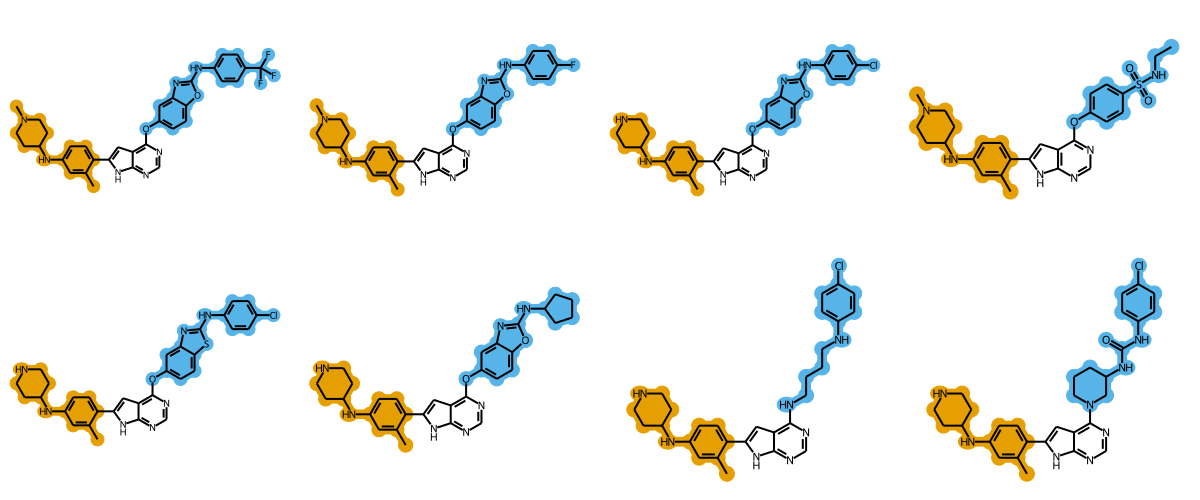

In [5]:
Image(draw_multiple(mms,groups,qcore,('R1','R2'),subImageSize=(300,250)))